In [1]:
# setup the environment
from detection import WatermarkInClassroom, WatermarkInClassroomLOCNESS, WatermarkInClassroomWeighted
from detection_utils import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

temp = 0.7
ngram = 4
model = "phi"
method = "openai"

prompt = 'P1'
df = load_dataset(data='ETS', model_list=[model], method_list=[method], ngram=ngram)

df = df[df['Prompt'] == prompt]

base = 1
alternatives = [2, 3, 4, 5, 6, 7]
adjust_alpha = 0.05
random_seed = 0

Loading essays from: results/ETS_corpus_sampled/phi/openai/temp0.7_ngram4/1/results.jsonl
Loading essays from: results/ETS_corpus_sampled/phi/openai/temp0.7_ngram4/2/results.jsonl
Loading essays from: results/ETS_corpus_sampled/phi/openai/temp0.7_ngram4/3/results.jsonl
Loading essays from: results/ETS_corpus_sampled/phi/openai/temp0.7_ngram4/4/results.jsonl
Loading essays from: results/ETS_corpus_sampled/phi/openai/temp0.7_ngram4/5/results.jsonl
Loading essays from: results/ETS_corpus_sampled/phi/openai/temp0.7_ngram4/6/results.jsonl
Loading essays from: results/ETS_corpus_sampled/phi/openai/temp0.7_ngram4/7/results.jsonl


# The Problem

The professor is teaching a course in which students are required to submit written essays. While she permits moderate use of AI for tasks such as grammar correction, she is concerned that some students may rely on AI to generate substantial portions of their work.

Current watermarking techniques enable the professor to detect whether an essay contains AI-generated content, at a significance level $\alpha$. However, existing methods only provide a binary decision: either the essay contains AI-generated content or it does not.

This binary signal is insufficient for the professor’s purpose. Instead, she seeks a more nuanced understanding of the extent to which AI contributed to the essay. This would allow her to judge whether the AI usage is within an reasonable range, rather than simply flagging any presence of AI.

First, we use the ETS corpus to investigate the information hidden behind the watermark signal.

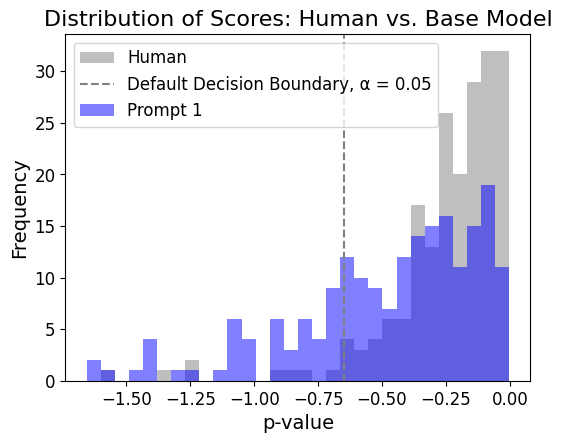

Human, 4.00 % samples below α = 0.05
Prompt 1, 25.50 % samples below α = 0.05


In [2]:
experiment = WatermarkInClassroom(df, model, method, base, alternatives, metric='pval', adjust_alpha=adjust_alpha, random_state=random_seed)
experiment.visualize_base_against_human()

# Visual Inspection

The professor teaches a large class of 100 students who all submitted essays on the same topic. She begins with a simple approach: visual inspection.

### Method: Histogram-Based Inspection

Upon receiving the essays, the professor obtains their $p$-values from a watermarking detection algorithm. She then creates a histogram of the $p$-values, visually inspects it, and determines whether some $p$-values appear too small. If certain essays exhibit very small $p$-values, she may conclude that those essays were potentially generated by AI in a way that violates the rules.

#### Pros:
- Simple and easy to implement.
- Requires no additional data.

#### Cons:
- Relies on the professor’s subjective judgment, which may result in inconsistent or biased decisions.
- It's unclear how to rigorously set a threshold to control the false positive rate (e.g., at $\alpha = 0.05$).
- As illustrated in the example below, while the histogram (shown in gray) may suggest that the left tail is not due to permitted AI usage, there is no principled way to draw a decision boundary.

Despite these limitations, visual inspection remains a reasonable approach when no prior information is available.


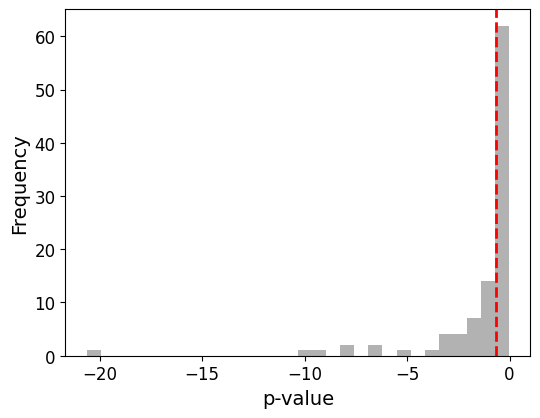

In [3]:
def visualize_outlier_wrapper(experiment, metric='pval', **kwargs):
    frac = 0.5
    n_total = 100
    n_samples = int(n_total*frac)
    df_inlier = experiment.df_heldout.sample(n=n_total-n_samples, random_state=42)
    df_outlier = experiment.df_outlier.sample(n=n_samples, random_state=42)
    experiment.visualize_outlier(df_inlier, df_outlier, metric=metric, **kwargs)
    

visualize_outlier_wrapper(experiment, mode="hide")

We reveal which essays follow the AI-usage guidelines below. There can be an overlap between the two distributions:

- When a student does not follow the AI-usage guidelines, the watermark signal is often strong, but this is not always the case.
- Conversely, some students who do follow the rules might still show low $p$-values.

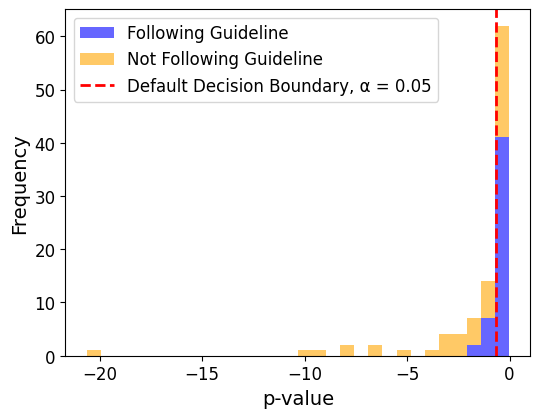

In [4]:
visualize_outlier_wrapper(experiment)

It is entirely possible that a student initially wrote a strong essay by themselves, but did not strictly follow the AI usage guidelines when polishing it. In this case, the resulting essay may contain a relatively small amount of AI-generated content.
 
Below are a few examples of essays with different prompts used to improve the quality. Nonetheless, the AI-edit resulted in a little change to the original essay. 

In practice, this level of AI involvement might be acceptable to the professor. After all, a well-written essay is a well-written essay, if AI's contribution is moderate and limited, the professor may choose to accept it.

High Similarity Score: bleu
0.9795189854912092, Prompt type: 5
Original Essay:
It is a common thought that it is better to have broad knowledge of many academic subjects than to specialize in one specific subject. This is no surprise when we think about how good it can make someone look in a cocktail party or in a fancy dinner. Indeed, who does not admire people who know about varied subjects? But can we say that having specialized knowledge is not as worthy as knowing a little bit about a lot of things?

I think that society does need specialists, that is people with highly specialized skills and knowledge. Indeed, some professions require high accuracy in knowledge. For example, a surgeon is generally specialized in a part of the body, as brain surgeons are. In my opinion, that is due to the fact that people concentrating on a subject learn a lot more about it than people learning a little bit about everything and who just cannot find the time to go further in each field. Other profe

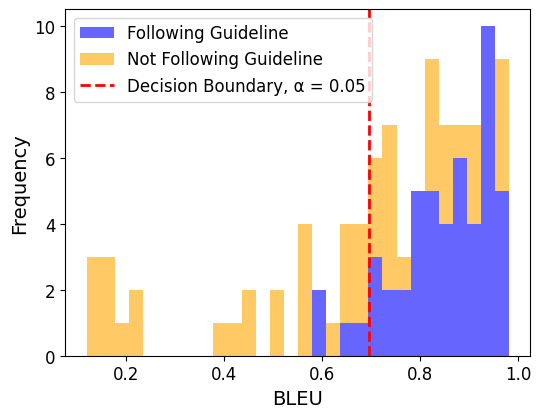

In [5]:
visualize_outlier_wrapper(experiment, metric='bleu', alpha=adjust_alpha)

## Refining the Definition of Guideline Violation
- Outliers: These are clear violations where AI usage leads to significant changes in the essay. An essay is classified as an outlier if
  1. The resulting BLEU score by following the AI-usage guidelines is higher than that by violating the guidelines, and  
  2. The resulting BLEU score by violating the guidelines is below the $\alpha = 0.05$ quantile of the test dataset.
- Suspects: A student violates AI-usage guidelines but the resulting essay shows only minor changes (high BLEU score).

In all our experiments, we make the assumption that the professor would be primarily concerned with identifying clear violations rather than "suspect" cases.

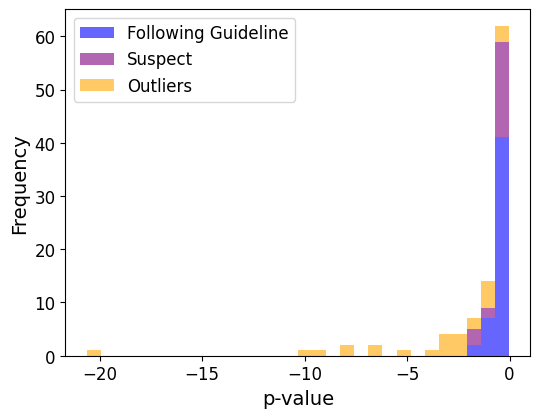

In [6]:
visualize_outlier_wrapper(experiment, metric='pval', mode="suspect")

# Scenario 1: Large Classrooms with Similar Past Assignments

If the professor would like to control the false positive rate at a target level (e.g., $\alpha = 0.05$), some prior information is needed. In this scenario, we assume the professor teaches a large-enrollment class and reuses essay prompts across semesters. As a result, she has access to a collection of essays from past years. She would like to use these historical essays to assess whether essays from the current cohort involves excessive AI usage.

We apply conformal methods to perform outlier detection with theoretical guarantees. Let $s(X)$ be the watermark score ($p$-value) returned by a watermark detection algorithm for an essay $X$. The score quantifies the strength of the watermark signal, with lower values indicating stronger evidence of AI editing.

The procedure is as follows:
1. **Simulate permitted AI usage** by applying guideline-compliant AI edits to past essays $X_1, X_2, \dots, X_n$. The resulting edited essays form the calibration set.
2. **Obtain watermark scores** by applying the watermarking detection algorithm to the calibration set. Denote the scores as $s_1,s_2,\cdots,s_n$.
3. **Evaluate a new submission** $X$ with corresponding watermark score $s$ by computing the conformal $p$-value:
$$
\hat u(s) = \frac{1 + \sum_{i=1}^n \mathbf{1}\{s_i \le s\}}{n+1},
$$
where ${\bf 1}(\cdot)$ is the indicator function.

4. **Decision Rule**: Flag $X$ as a likely violation if $\hat u(s) \le \alpha$. 

An example of this is shown in the figure below.

Running conformal tests with 50 in-domain training samples, random_seed=0
Training set size: 50
Number of inliers: 1024
Number of outliers: 565
Marginal Conformal p-values
False positive rate: 4.69%
Power: 79.65%


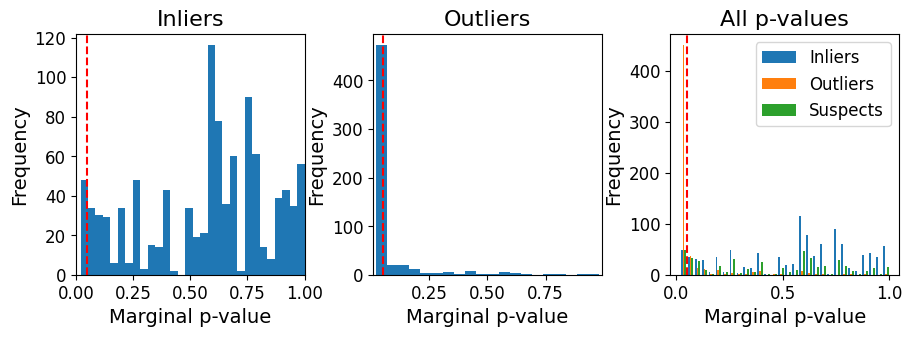

In [7]:
def run_conformal_tests_wrapper(experiment, n_trains, random_seed = random_seed, verbose = True, train_groups = False, **kwargs):
    results = []
    for n_train in n_trains:
        verbose_ = verbose
        result = {}
        result['n_train'] = n_train
        if verbose_:
            print(f"Running conformal tests with {n_train} in-domain training samples, random_seed={random_seed}")
        df_train = experiment.df_heldout.sample(n=n_train, random_state=random_seed)
        if verbose_:
            print(f"Training set size: {len(df_train)}")
        if train_groups:
            result |= experiment.run_conformal_tests(df_train, train_groups = df_train['essay_id'], verbose=verbose_, **kwargs)
        else:
            result |= experiment.run_conformal_tests(df_train, verbose=verbose_, **kwargs)
        verbose_ = False
        results.append(result)
    return results

# call it
result = run_conformal_tests_wrapper(experiment, n_trains = [50], alpha=0.05, save_path = f"figs/{model}_{method}_{base}_scenario_1.png")

# Scenario 2: Small Classrooms with Limited I.I.D. Data
Suppose the professor teaches a small seminar course with only 10–20 students. In such cases, she may not have access to enough historical calibration data. Moreover, she may update the assignments to reflect the latest developments in the field, or teach a new course with no prior data. 

Despite these limitations, instructors often have access to groups of past assignments that share similar educational goals or quantitative skills. These naturally form related but non-i.i.d. groups of data. To handle such settings, we apply hierarchical conformal prediction method introduced in [Distribution-free inference with hierarchical data](https://arxiv.org/pdf/2306.06342).

Suppose the professor has access to $K$ groups of calibration essays, where group $k$ contains $n_k$ essays. The procedure is as follows:

1. **Collect Scores** for each group $S_k = \{s_{k,1}, \dots, s_{k,n_k}\}$. 
2. **Evaluate a new submission**: Given a new submission $X$ with watermark score $s$, compute the hierarchical conformal $p$-value
$$
\hat u_{\text{hier}}(s) = \frac{1}{K+1} \left[ 1 + \sum_{k=1}^{K} \frac{1}{n_k} \sum_{i=1}^{n_k} \mathbf{1}\{s_{k,i} \le s\} \right].
$$
3. **Decision Rule**: Flag $X$ as a likely violation if $\hat u_{\text{hier}}(s) \le \alpha$.

An illustration of this method is shown in the figure below.

Loading essays from: results/LOCNESS_sampled/phi/openai/temp0.7_ngram4/1/results.jsonl
Loading essays from: results/LOCNESS_sampled/phi/openai/temp0.7_ngram4/2/results.jsonl
Loading essays from: results/LOCNESS_sampled/phi/openai/temp0.7_ngram4/3/results.jsonl
Loading essays from: results/LOCNESS_sampled/phi/openai/temp0.7_ngram4/4/results.jsonl
Loading essays from: results/LOCNESS_sampled/phi/openai/temp0.7_ngram4/5/results.jsonl
Loading essays from: results/LOCNESS_sampled/phi/openai/temp0.7_ngram4/6/results.jsonl
Loading essays from: results/LOCNESS_sampled/phi/openai/temp0.7_ngram4/7/results.jsonl
count                    200
unique                   165
top       <ICLE-US-SCU-0004>
freq                       3
Name: essay_id, dtype: object
Running conformal tests with 200 in-domain training samples, random_seed=42
Training set size: 200
Number of inliers: 185
Number of outliers: 103
Marginal Conformal p-values
False positive rate: 4.32%
Power: 76.70%


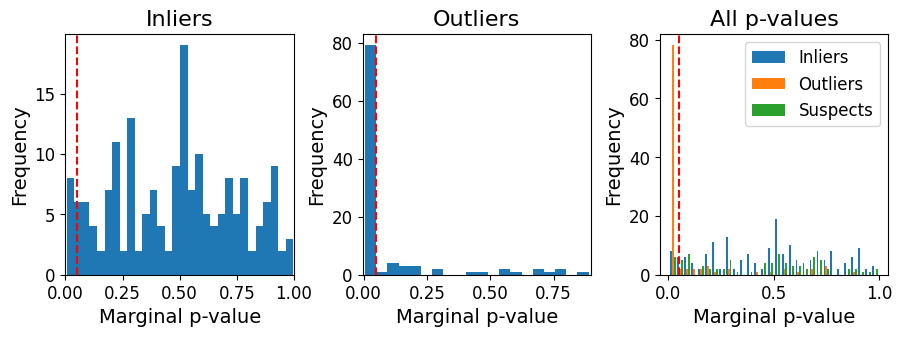

In [8]:
LOCNESS_df = load_dataset(data='LOCNESS', model_list=[model], method_list=[method], ngram=ngram)

experiment_LOCNESS = WatermarkInClassroomLOCNESS(LOCNESS_df, model, method, base, alternatives, metric='pval', adjust_alpha=adjust_alpha, random_state = random_seed)

print(experiment_LOCNESS.df_heldout['essay_id'].describe())

result = run_conformal_tests_wrapper(experiment_LOCNESS, random_seed = 42, n_trains = [200], alpha=0.05, train_groups = True, save_path = f"figs/{model}_{method}_{base}_scenario_2.png")

# Scenario 3: Fairer Classrooms: Distribution Shift with Small Subgroups

In many cases, the calibration data may not be i.i.d. due to distribution shifts. For example, a professor teaches a course with a diverse student population, including non-native English speakers (NNES).

When using AI for permitted grammatical assistance, essays by non-native speakers can show stronger watermarking signals compared to those by native speakers. With the same essay-editing prompt, the watermarking $p$-values for NNES students (blue) are significantly lower than those for native speakers (green). A comparison of the BLEU scores between the original and edited essays below indicates the AI-editing process is more likely to change the content of the essay for non-native English speakers than for native English speakers. If the professor uses the same detection threshold for both groups, the FPR for NNES students will be much higher than that for native speakers, leading to unfair treatment. 

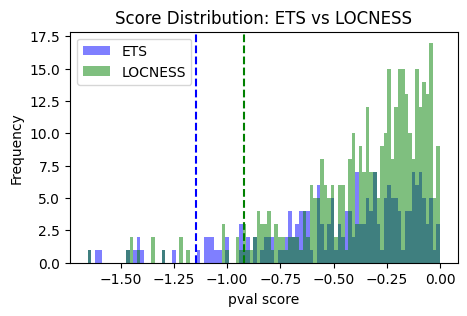

In [9]:
experiment_weighted = WatermarkInClassroomWeighted(df, model, method, base, alternatives, metric='pval', adjust_alpha=adjust_alpha, df_majority=LOCNESS_df, random_state = random_seed)

experiment_weighted.compare_score_distribution(metric = 'pval')

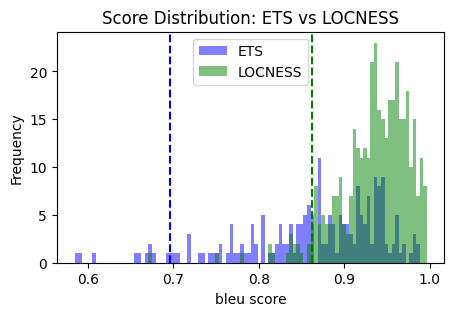

In [10]:
experiment_weighted.compare_score_distribution(metric = 'bleu')

Even though the professor has access to calibration data from both groups, the number of essays from NNES students can be much smaller than that from native speakers. In this case, only using the calibration data from NNES students may not be sufficient to provide a reliable threshold due to the small sample size. 

To address this issue, we propose a weighted conformal prediction method that combines the calibration data from both groups while accounting for the distribution shift [Conformal Prediction Under Covariate Shift](https://arxiv.org/abs/1904.06019).

The procedure is as follows:
1. **Collect scores**: Let $S = \{s_1,\dots,s_n\}$ the watermark scores of the calibration essays and $s$ that of a new submission $X$ from a NNES. 

2. **Compute normalized importance weights**:
$$
w_i(s) = \frac{\hat q(s_i)/\hat p(s_i)}{\sum_{j=1}^n \hat q(s_j)/\hat p(s_j) +\hat q(s)/\hat p(s) }, \quad w(s) = \frac{\hat q(s)/\hat p(s)}{\sum_{j=1}^n \hat q(s_j)/\hat p(s_j) +\hat q(s)/\hat p(s) },
$$
where
- $\hat p$ is the estimated density of the full calibration distribution,
- $\hat q$ is the estimated density of the target-group distribution (e.g., NNES students).
3. **Decision rule**: Flag $X$ as a likely violation if the weighted $p$-value falls below a chosen significance level $\alpha$:
$$
\sum_{i=1}^n w_i(s) \cdot {\bf 1}\{ s_i \leq s \} + w(s) < \alpha.
$$


Here we plot the estimation of density $p$ and $q$ using different methods.

Running conformal tests with 5 in-domain training samples, random_seed=0
Training set size: 5


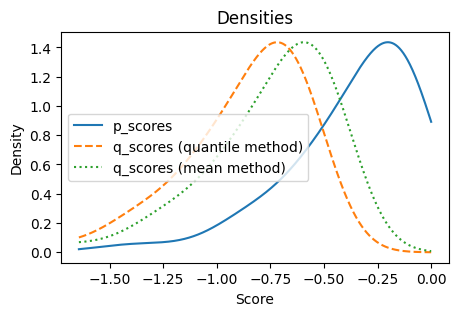

Number of outliers: 565
Marginal Conformal p-values
In Distribution Only False positive rate: 0.00
In Distribution Only Power: 0.00
Combined Unweighted False positive rate: 13.48
Combined Unweighted Power: 89.73
Combined Weighted (quantile) False positive rate: 4.39
Combined Weighted (quantile) Power: 78.94
Combined Weighted (mean) False positive rate: 5.08
Combined Weighted (mean) Power: 81.24
Running conformal tests with 15 in-domain training samples, random_seed=0
Training set size: 15


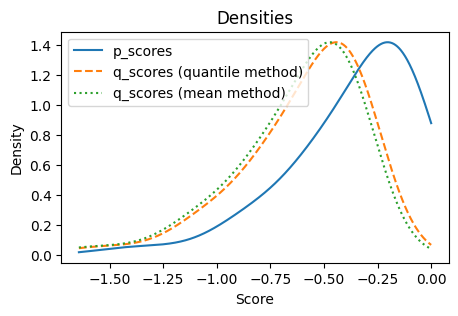

Number of outliers: 565
Marginal Conformal p-values
In Distribution Only False positive rate: 0.00
In Distribution Only Power: 0.00
Combined Unweighted False positive rate: 13.48
Combined Unweighted Power: 89.73
Combined Weighted (quantile) False positive rate: 7.23
Combined Weighted (quantile) Power: 84.42
Combined Weighted (mean) False positive rate: 7.03
Combined Weighted (mean) Power: 84.42
Running conformal tests with 30 in-domain training samples, random_seed=0
Training set size: 30


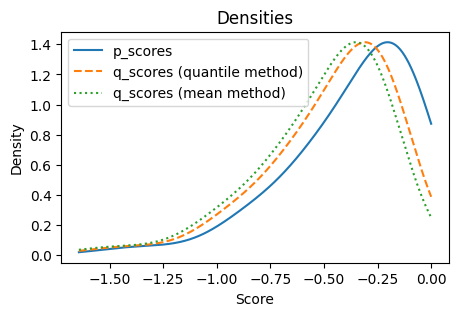

Number of outliers: 565
Marginal Conformal p-values
In Distribution Only False positive rate: 8.01
In Distribution Only Power: 86.02
Combined Unweighted False positive rate: 13.48
Combined Unweighted Power: 89.73
Combined Weighted (quantile) False positive rate: 10.74
Combined Weighted (quantile) Power: 87.79
Combined Weighted (mean) False positive rate: 8.89
Combined Weighted (mean) Power: 87.08


In [11]:
results = run_conformal_tests_wrapper(experiment_weighted, n_trains = [5, 15, 30], alpha=0.05, verbose=True)